In [1]:
import pandas as pd
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt

### USING scienceplots BROKE THINGS FOR THE SKYMAPS :'(
### MADE SEPARATE NOTEBOOK WHERE scienceplots WAS _NOT_ USED BUT CONTAINS SKYMAPS
import scienceplots
plt.rcParams['text.usetex'] = False

plt.style.use(['science','ieee', 'bright'])

# NOTE_: if font error arise, run the following in terminal
# sudo apt install msttcorefonts -qq
# rm ~/.cache/matplotlib -rf   


# Import utilities and define global parameters

In [2]:
from mapXmap_utils import make_skymap, normalize_skymap, cross_cl, map2alm, alm2cl, blur_map, \
    plot_corr_func, plot_Cls, plot_Dls, blur_map, blur_mapANDalm, plot_skymap, plot_skymap_special

# set universal nside value (override; default is 512 from mapXmap_utils)
nside = 128


# GRB x GW Cross-correlation

1.0 1.0 0.9999999999999999 1.0


/home/theleizurc/anaconda3/envs/gw-school-2025/lib/python3.11/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/home/theleizurc/anaconda3/envs/gw-school-2025/lib/python3.11/site-packages/scipy/special/_orthogonal.py:2492: RuntimeWarning: overflow encountered in scalar power
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/home/theleizurc/anaconda3/envs/gw-school-2025/lib/python3.11/site-packages/scipy/special/_orthogonal.py:2492: RuntimeWarning: invalid value encountered in scalar divide
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n


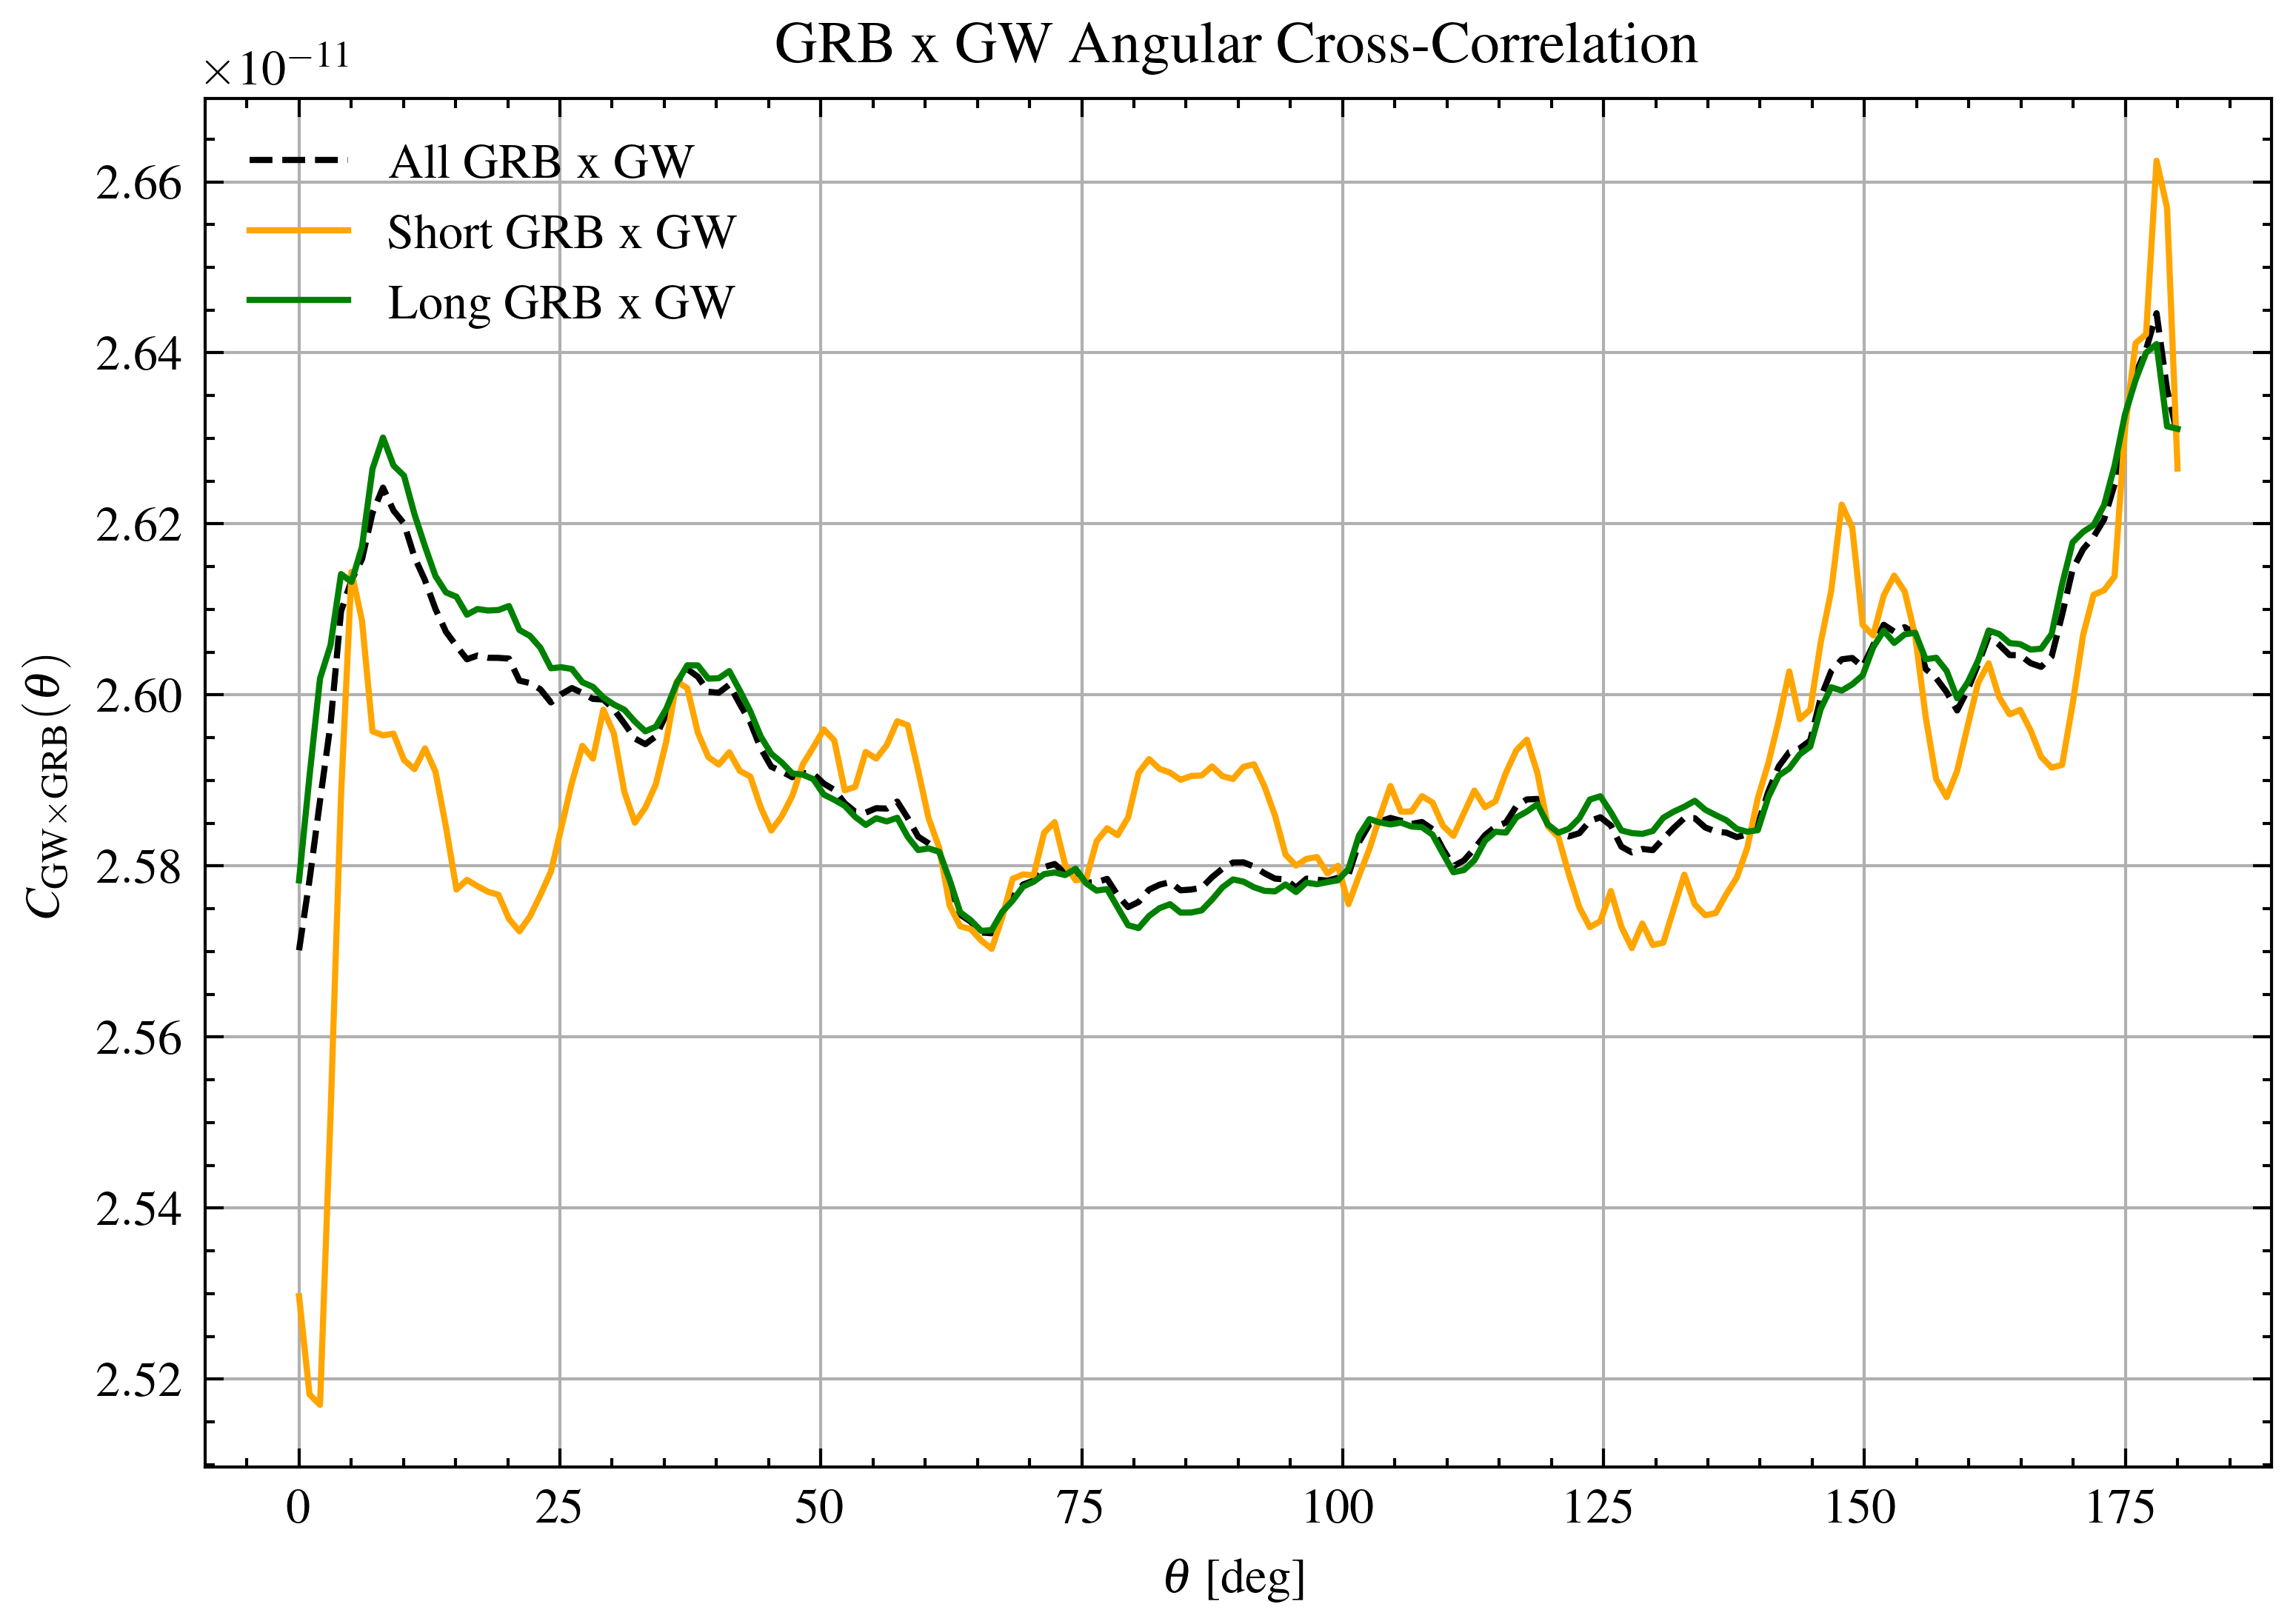

In [3]:
# set maximum l for cut-off for cross-correlations
lmax = 180

# load GW map data (directory for stacked GW events skymap as .npy file; made somewhere else)
GW_dir = r'GW_combined_skymap.npy'
GW_skymap = np.load(GW_dir)

# normalize GW map
GW_skymap = normalize_skymap(GW_skymap, shift_min=False)


# load GRB data
GRB_file_path = "GRB_Summary_table.txt" # just using summary data (from SWIFT/Fermi?)
df = pd.read_csv(GRB_file_path, sep='\s+', comment='#', header=None)
df.columns = [
    "GRB_Name", "Trigger", "Trigger_Time", "RA_deg", "Dec_deg", "pos_err", "T90",
    "T90_err", "T90_start", "Fluence", "Fluence_err", "Redshift", "T100",
    "GBM_located", "mjd"]

# Filter for valid burst duration and sky position error
df_filt = df[(df['T90']>=0) & (df['pos_err']>=0)]

# burt time filters for short and long, respectively
df_filt_sGRB = df_filt[df_filt['T90']<=2.0]
df_filt_lGRB = df_filt[df_filt['T90']>2.0]

# make GRB skymaps
GRB_full_sm = make_skymap(ra_deg = df_filt['RA_deg'].to_numpy(),
                          dec_deg = df_filt['Dec_deg'].to_numpy(), nside=nside)
sGRB_skymap = make_skymap(ra_deg = df_filt_sGRB['RA_deg'].to_numpy(),
                          dec_deg = df_filt_sGRB['Dec_deg'].to_numpy(), nside=nside)
lGRB_skymap = make_skymap(ra_deg = df_filt_lGRB['RA_deg'].to_numpy(),
                          dec_deg = df_filt_lGRB['Dec_deg'].to_numpy(), nside=nside)

# normalize GRB skymaps
GRB_full_sm = normalize_skymap(GRB_full_sm)
sGRB_skymap = normalize_skymap(sGRB_skymap)
lGRB_skymap = normalize_skymap(lGRB_skymap)
# normalization check:
print(GW_skymap.sum(), GRB_full_sm.sum(), sGRB_skymap.sum(), lGRB_skymap.sum())


# direct cross-cl from original maps, l≤26

cl_GRBxGW_drct = cross_cl(hp.alm2map(map2alm(GW_skymap, lmax=lmax), nside=nside),
                          hp.alm2map(map2alm(GRB_full_sm, lmax=lmax), nside=nside), lmax=lmax)
cl_sGRBxGW_drct = cross_cl(hp.alm2map(map2alm(GW_skymap, lmax=lmax), nside=nside),
                           hp.alm2map(map2alm(sGRB_skymap, lmax=lmax), nside=nside), lmax=lmax)
cl_lGRBxGW_drct = cross_cl(hp.alm2map(map2alm(GW_skymap, lmax=lmax), nside=nside),
                           hp.alm2map(map2alm(lGRB_skymap, lmax=lmax), nside=nside), lmax=lmax)


### plot angular cross-correlation function, C(Θ) vs Θ
plot_corr_func([cl_GRBxGW_drct, cl_sGRBxGW_drct, cl_lGRBxGW_drct],
               Cl_labels=['All GRB x GW', 'Short GRB x GW', 'Long GRB x GW'],
               colors=['black', 'orange', 'green'], figsize=(6, 4),
               linestyles=['--', None, None], title='GRB x GW Angular Cross-Correlation',
               ylabel=r'$C_{\text{GW}\times\text{GRB}}(\theta)$', ylog=False, save=True, save_ext='.pdf')

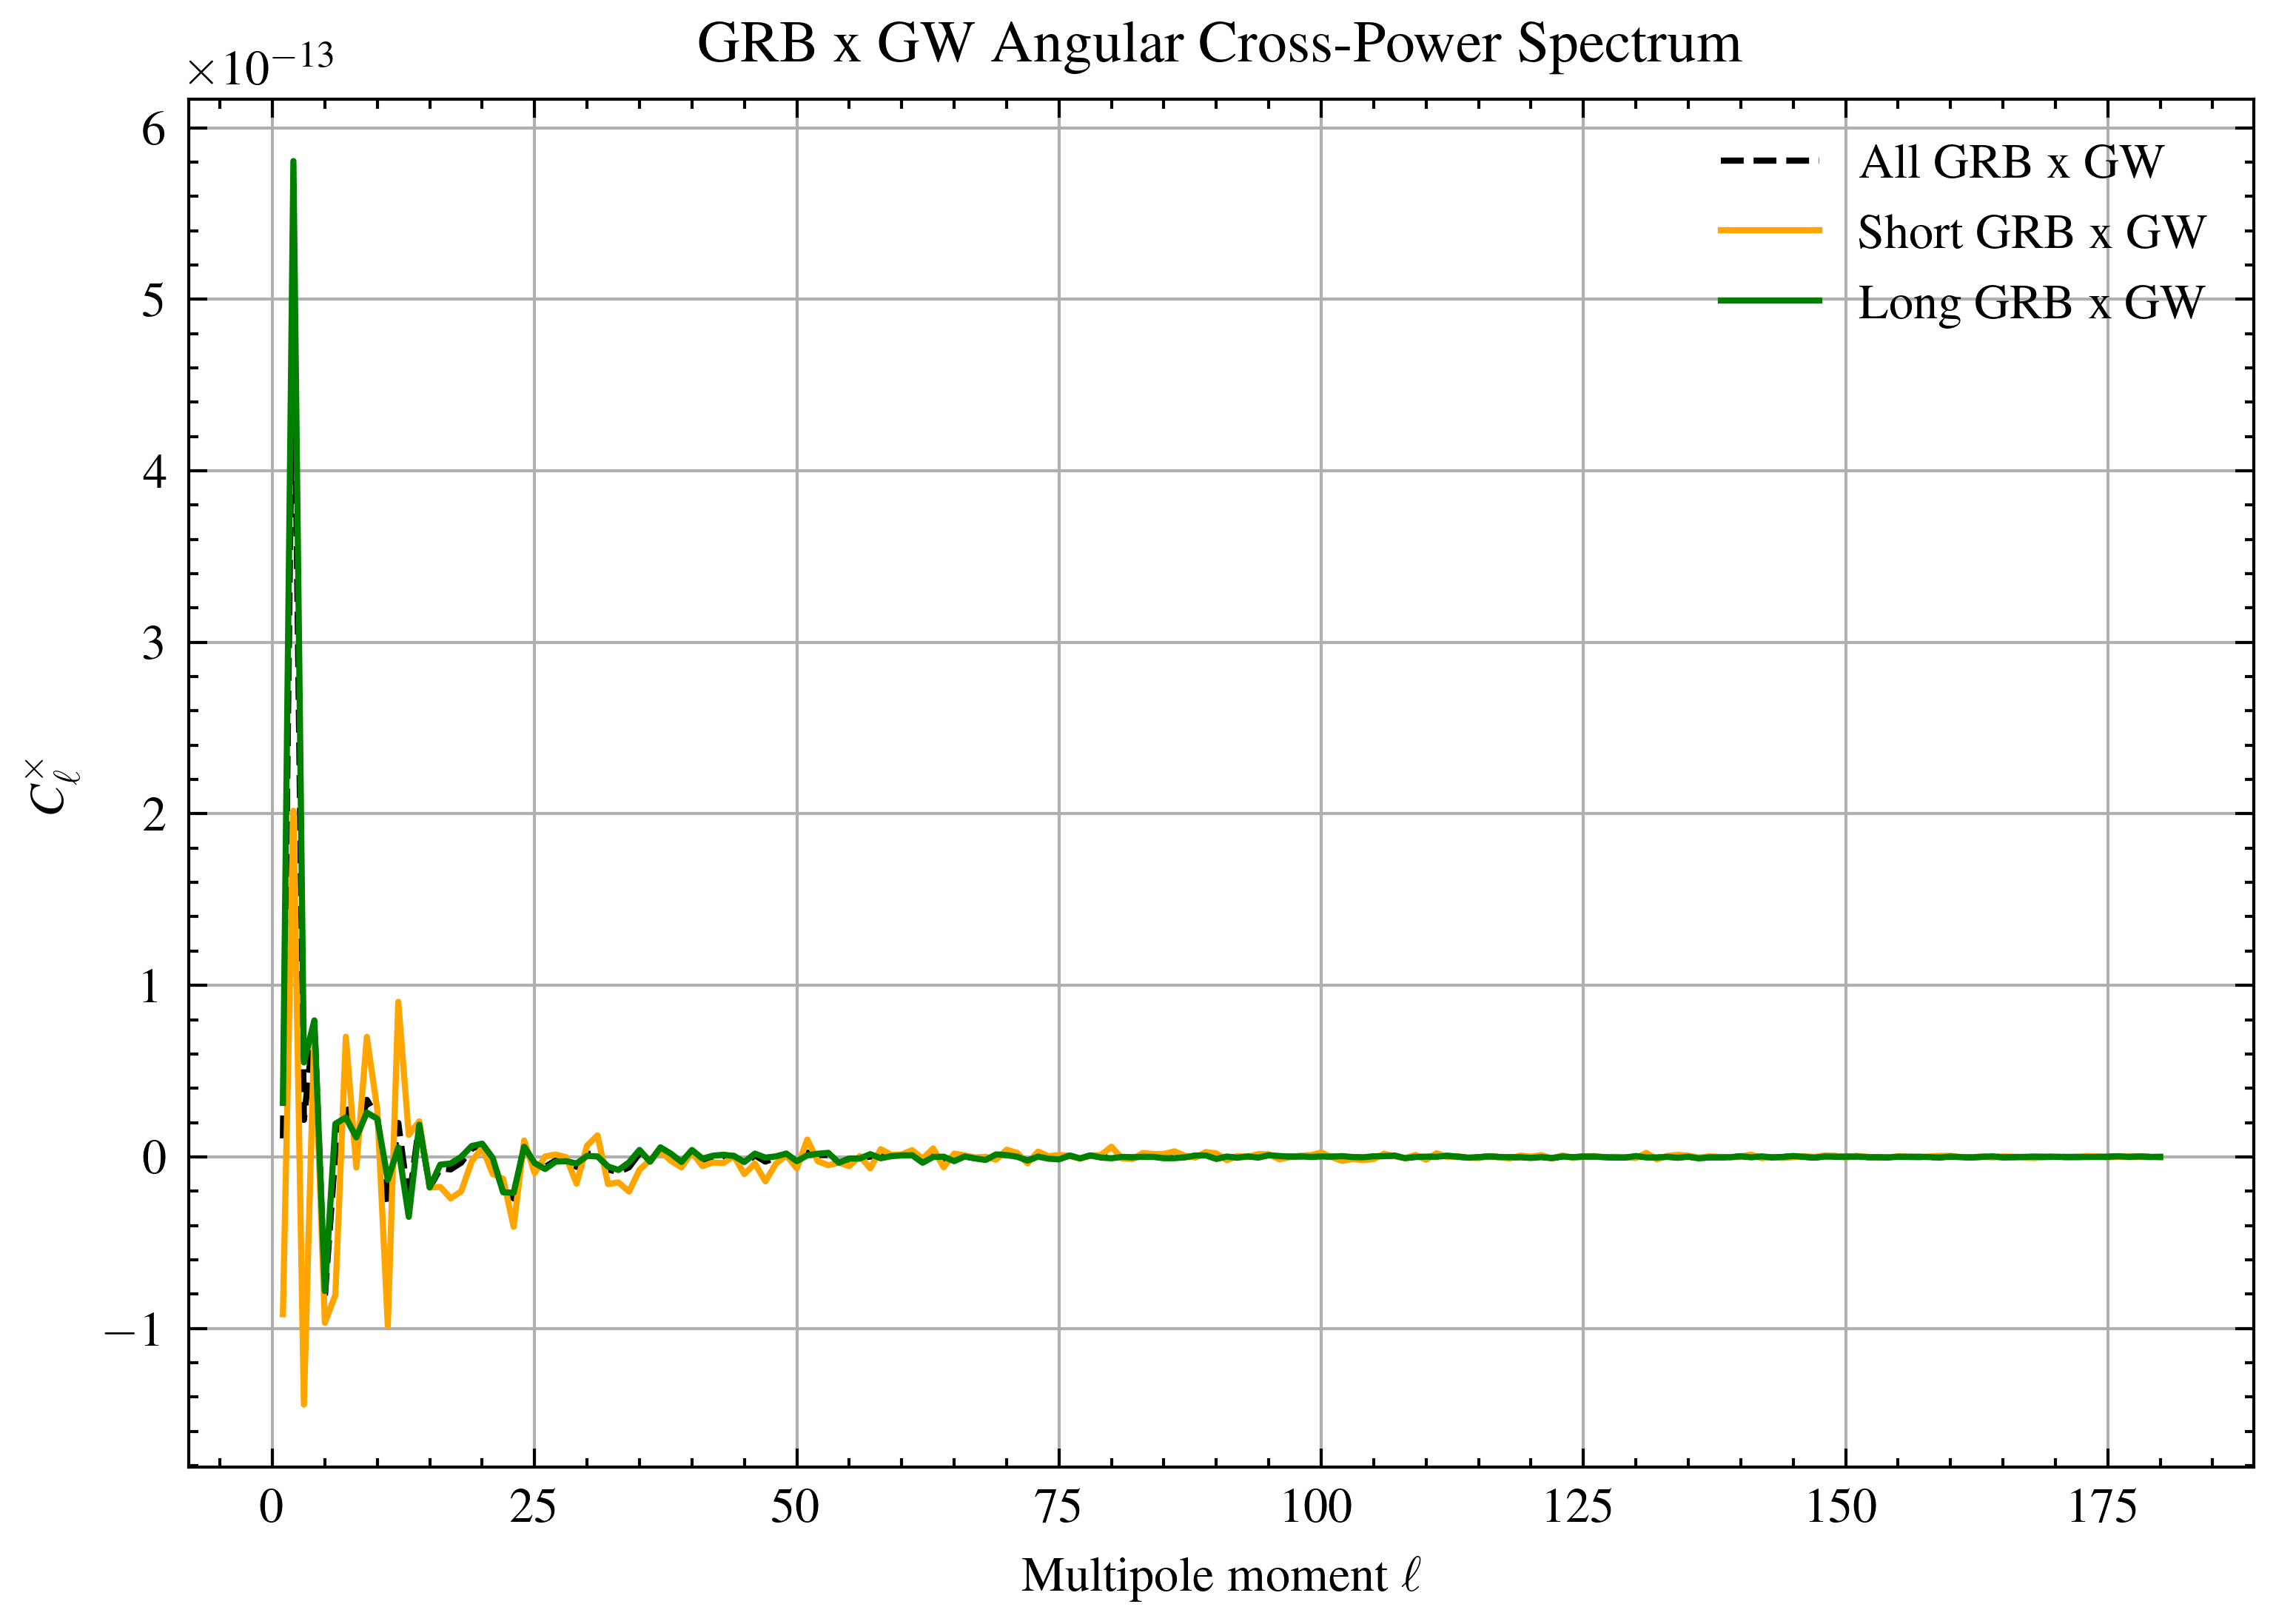

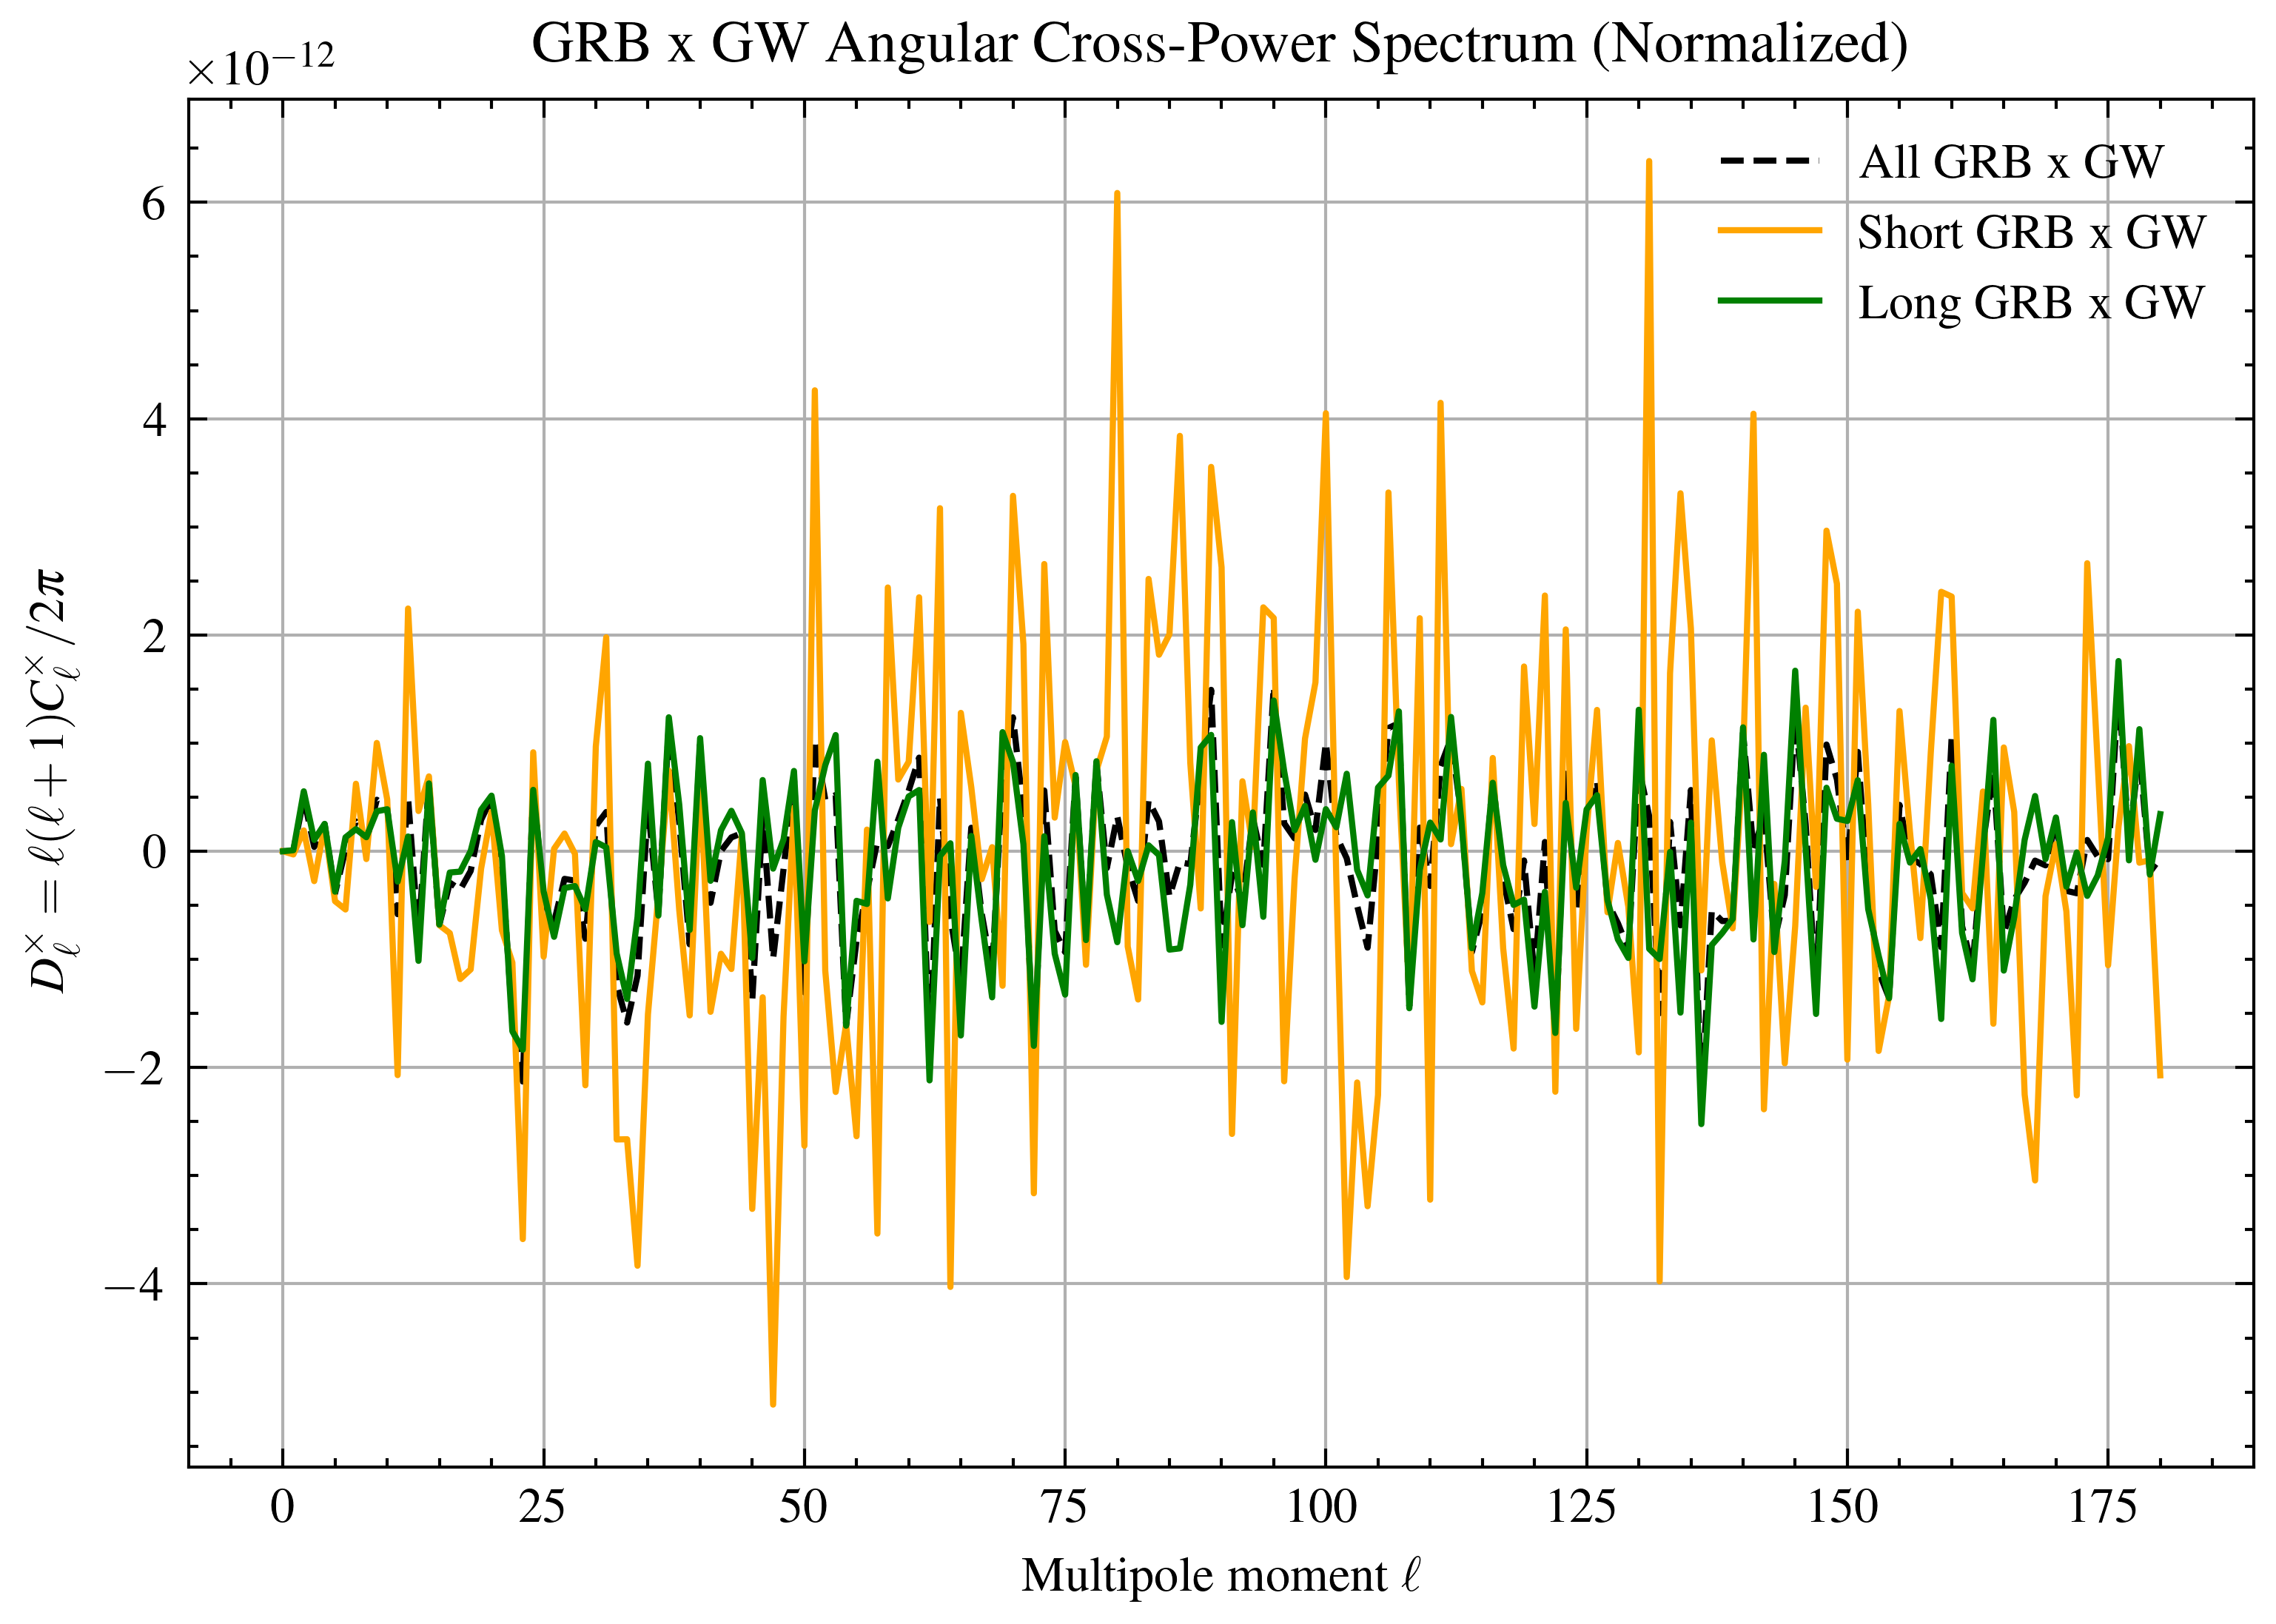

In [4]:
# plot power spectrum, C_l vs l
plot_Cls([cl_GRBxGW_drct, cl_sGRBxGW_drct, cl_lGRBxGW_drct],
         Cl_labels=['All GRB x GW', 'Short GRB x GW', 'Long GRB x GW'],
         colors=['black', 'orange', 'green'], monopole_term=False, figsize=(6,4),
         linestyles=['--', None, None], title='GRB x GW Angular Cross-Power Spectrum',
         ylabel=r'$C^\times_\ell$', ylog=False, xlog=False)

# plot normalized power spectrum, D_l vs l
plot_Dls([cl_GRBxGW_drct, cl_sGRBxGW_drct, cl_lGRBxGW_drct],
         Cl_labels=['All GRB x GW', 'Short GRB x GW', 'Long GRB x GW'],
         colors=['black', 'orange', 'green'], figsize=(6,4),
         linestyles=['--', None, None], title='GRB x GW Angular Cross-Power Spectrum (Normalized)',
         ylabel=r'$D^\times_\ell = \ell (\ell+1)C^\times_\ell/{2 \pi}$',
         ylog=False, xlog=False)

# ↓↓↓ other plots ↓↓↓

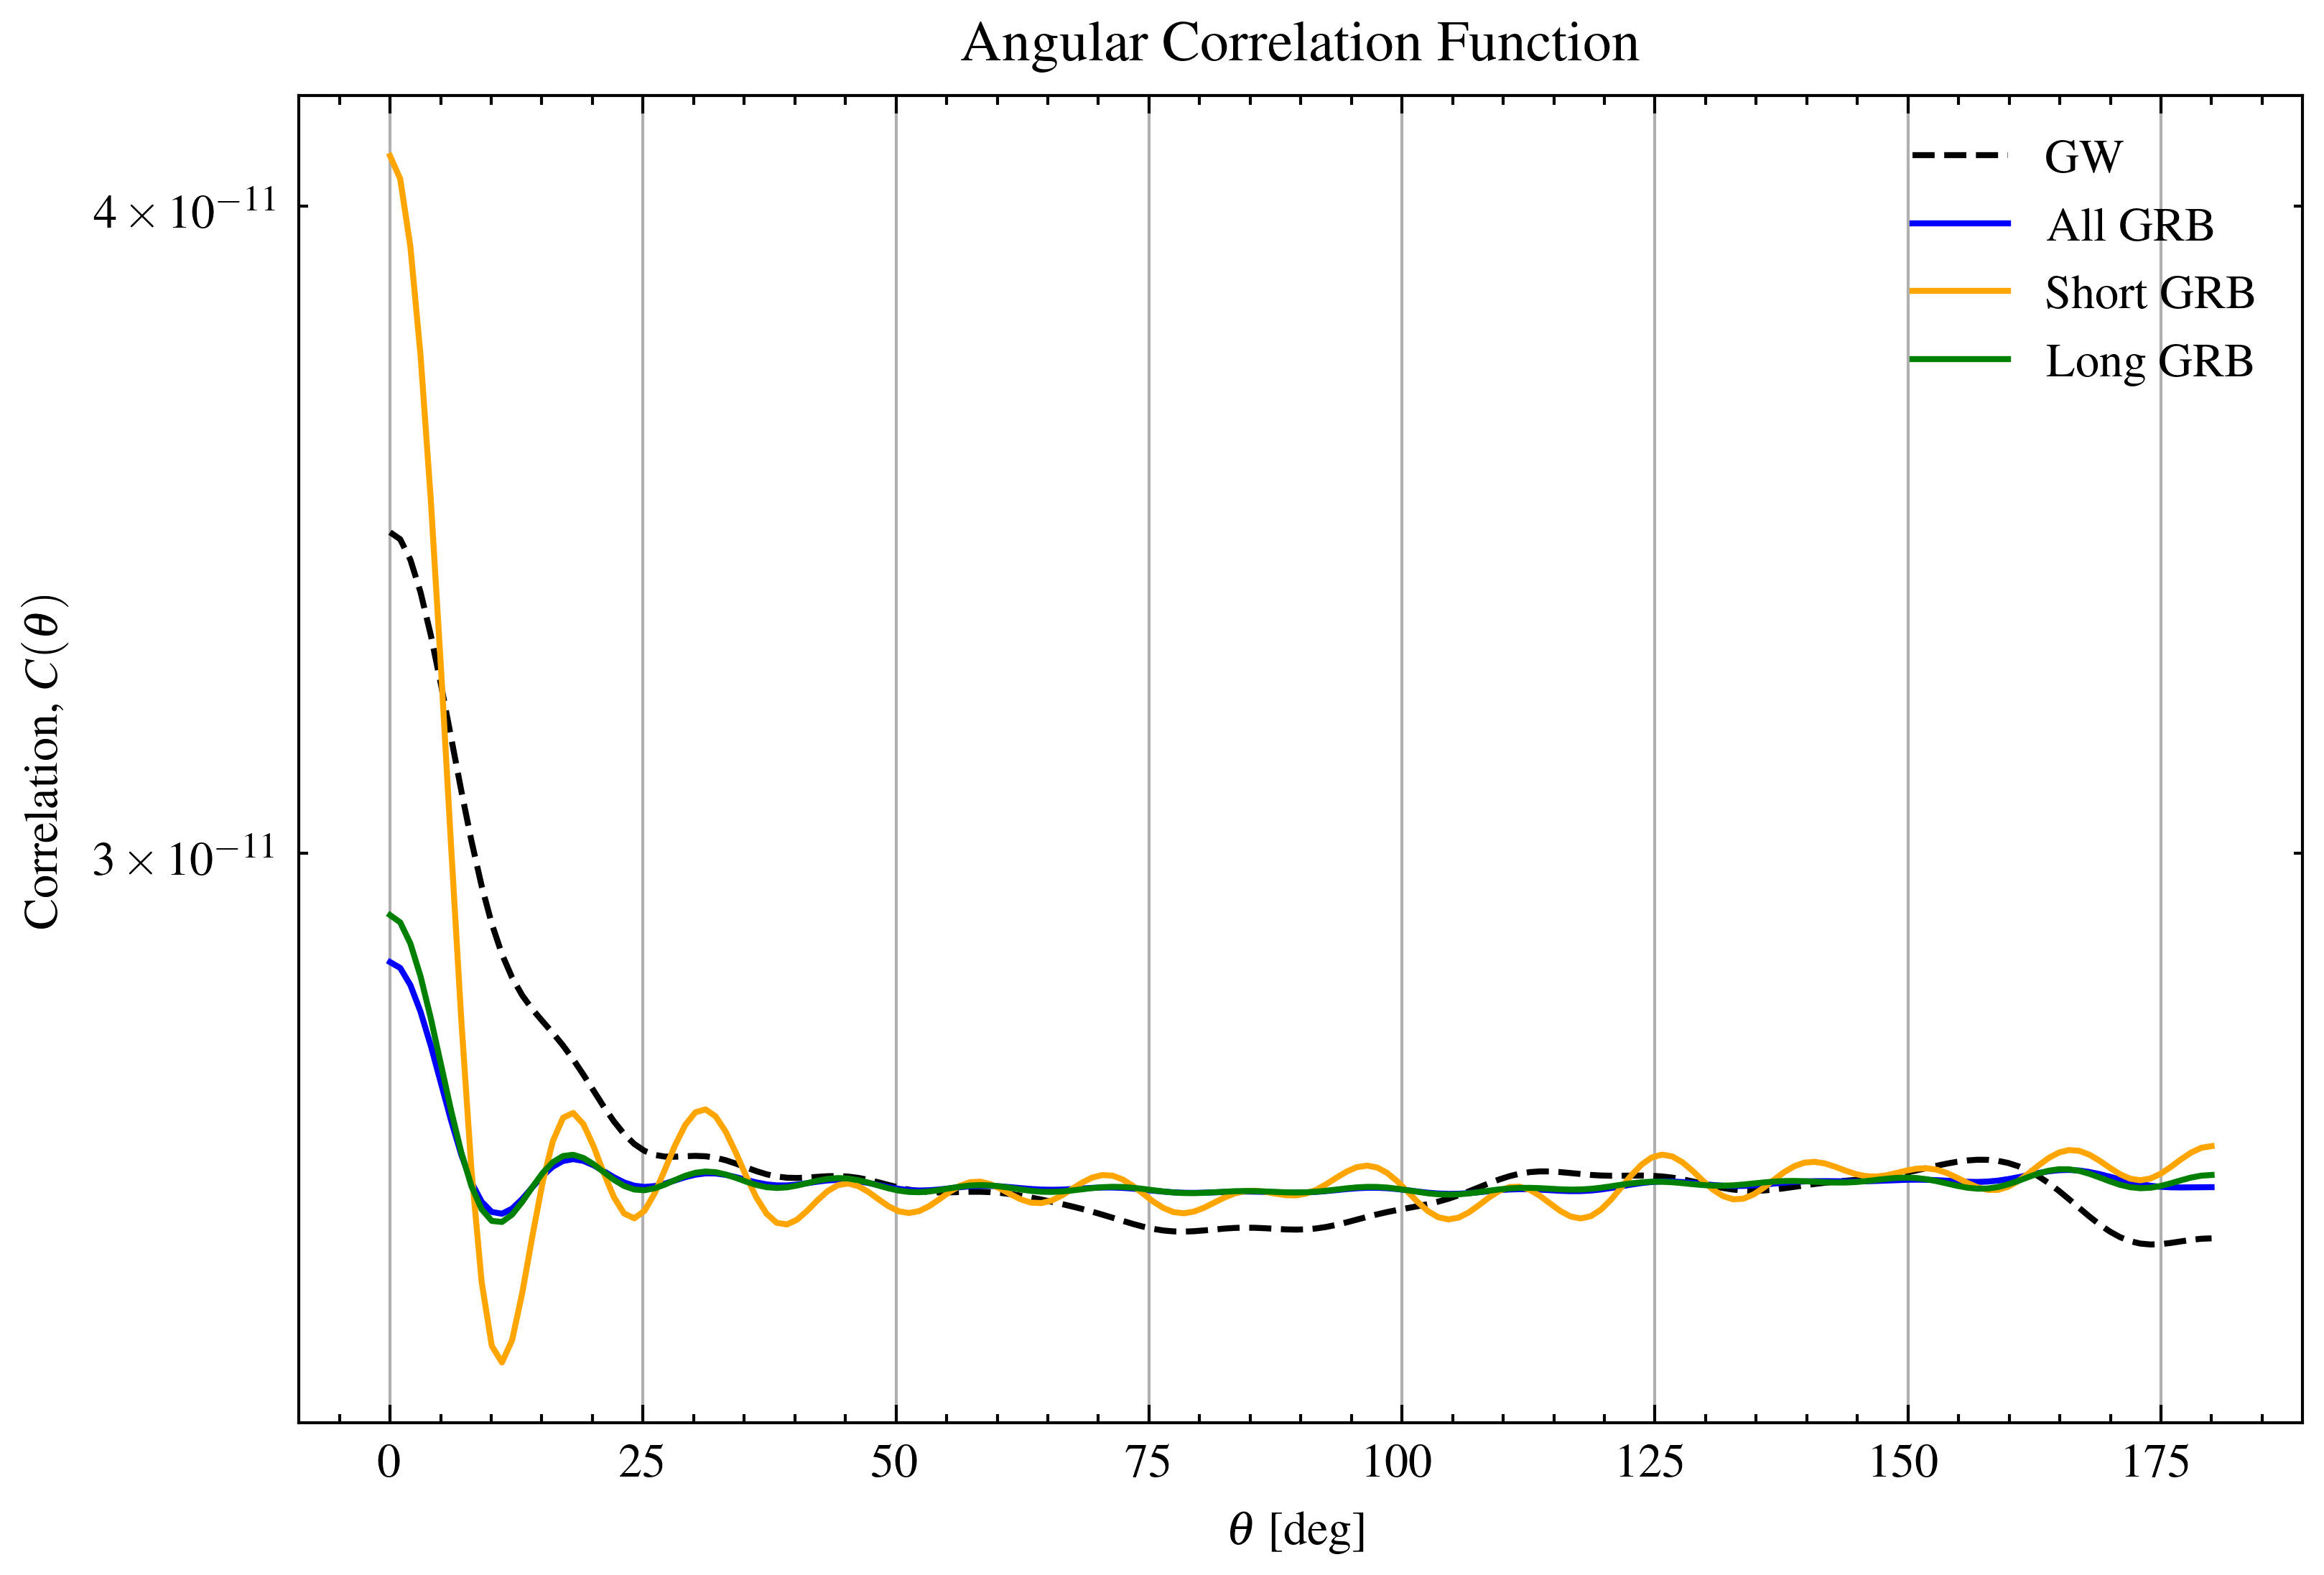

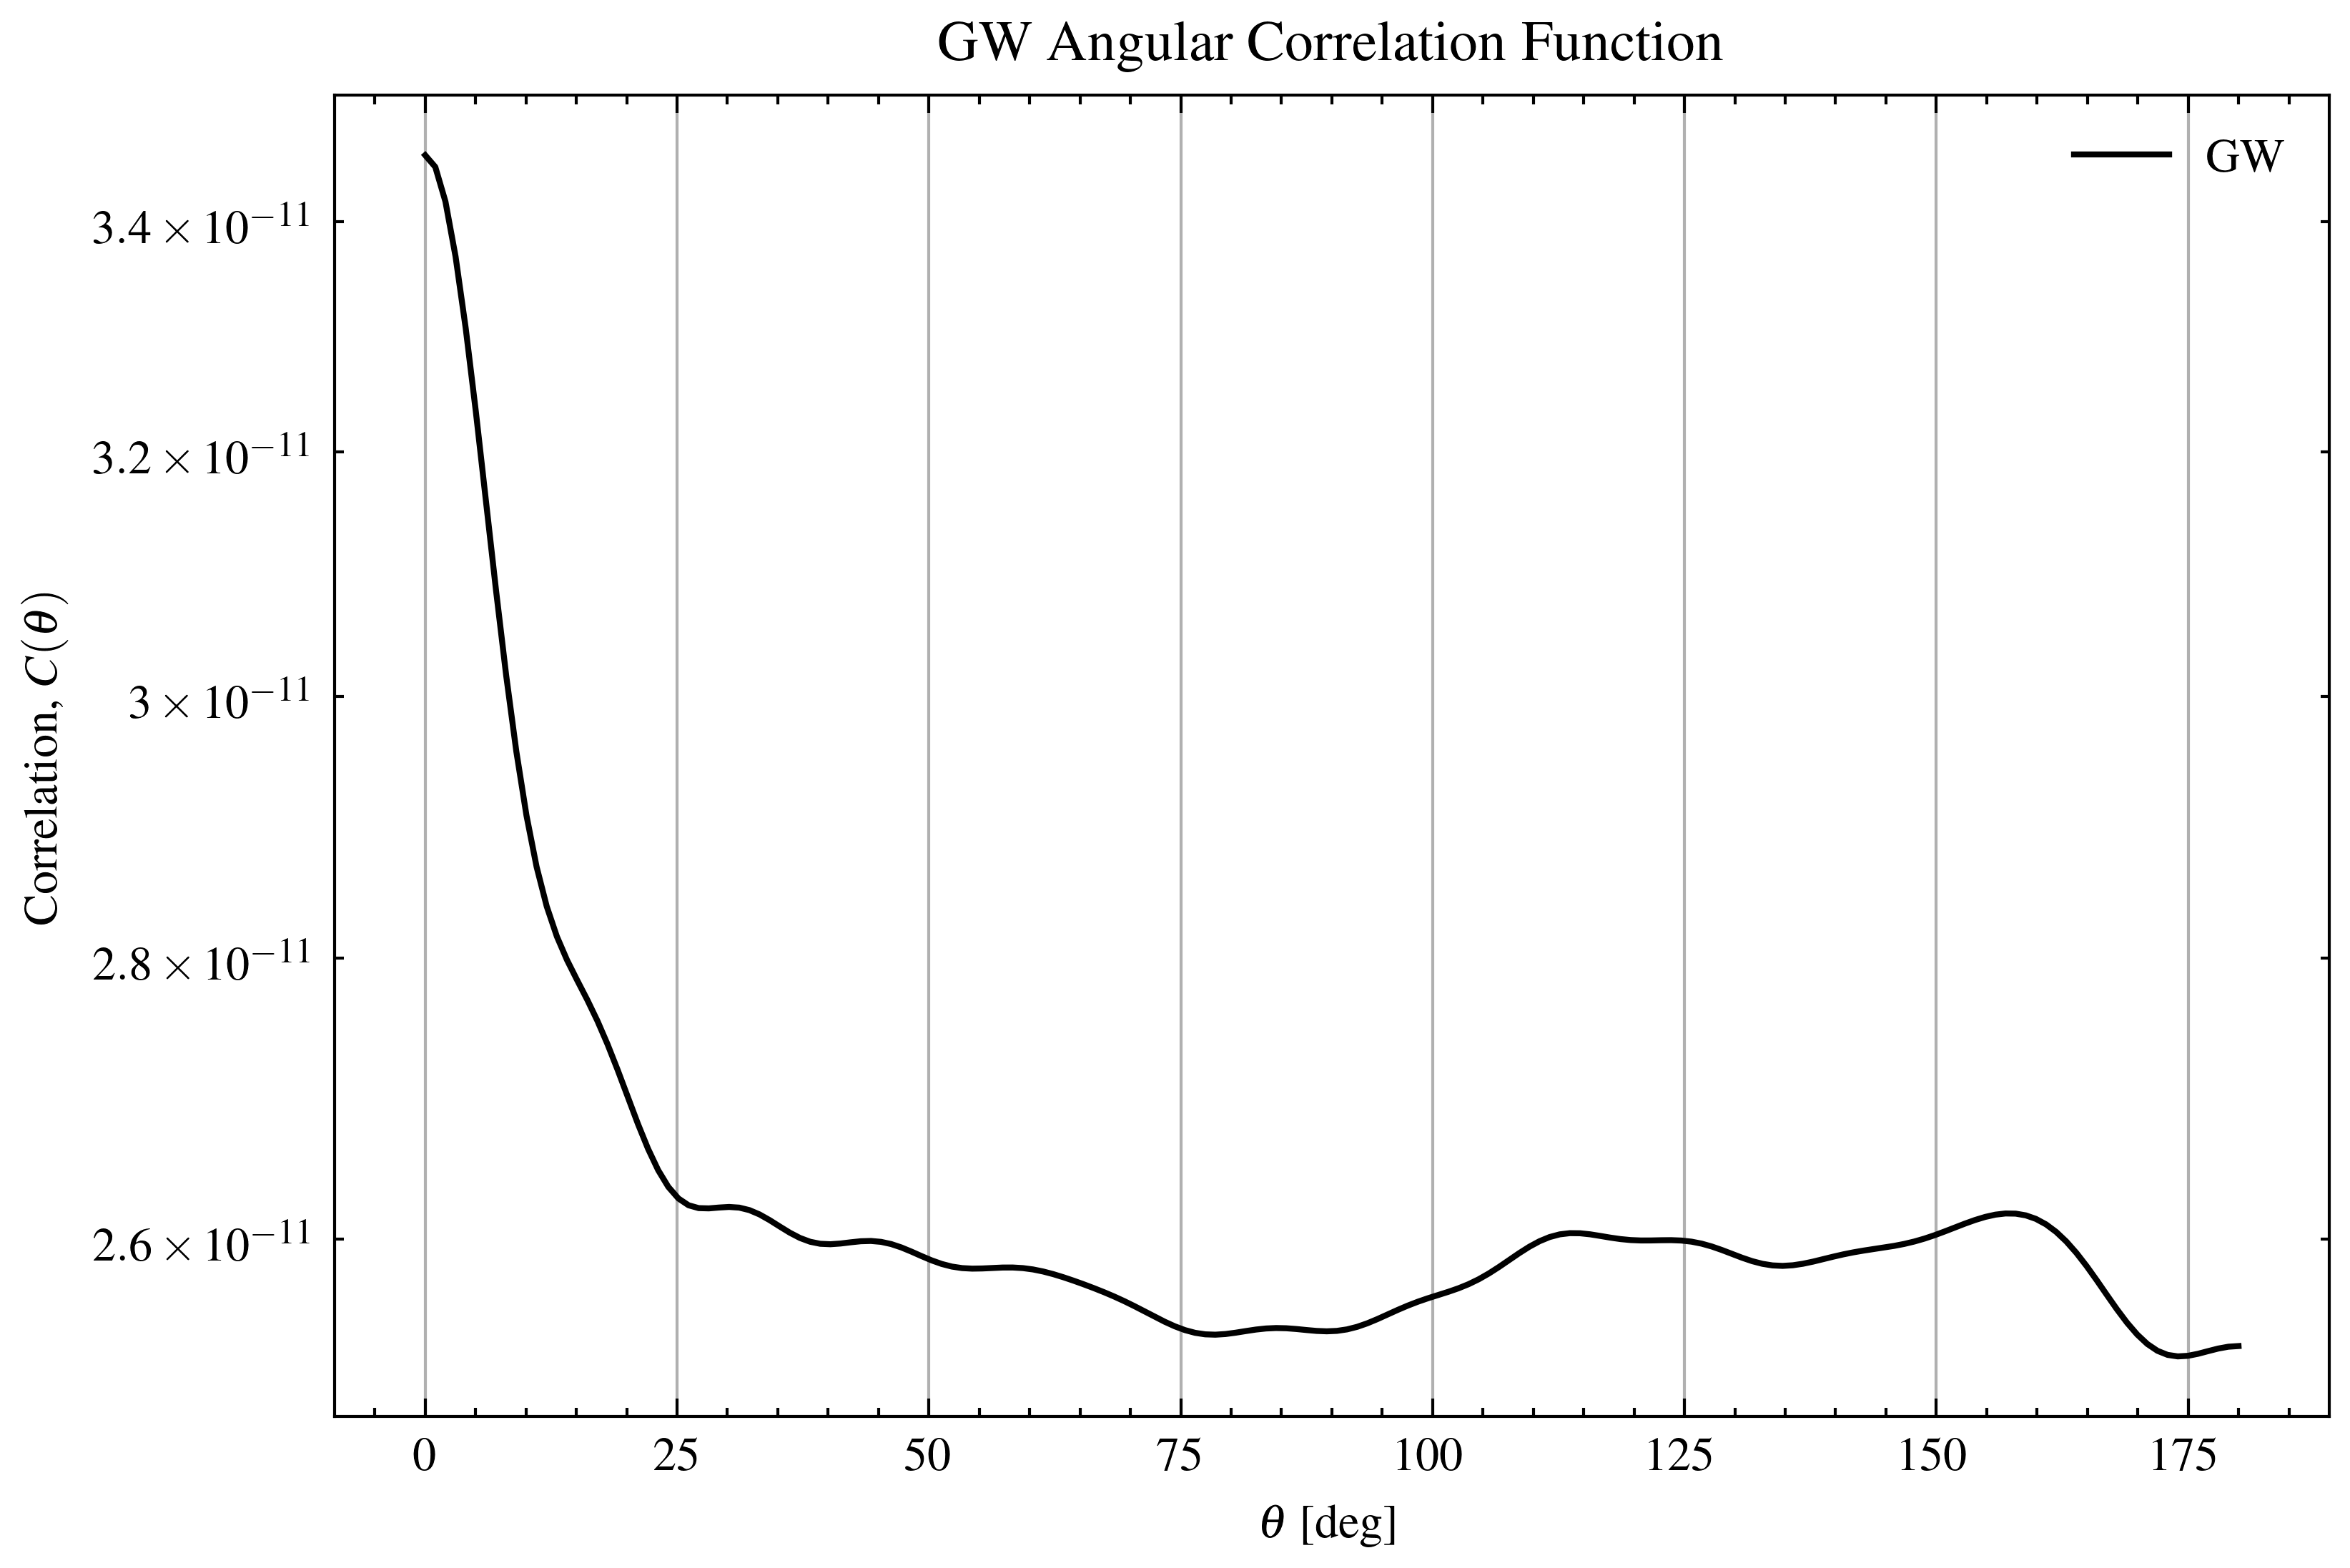

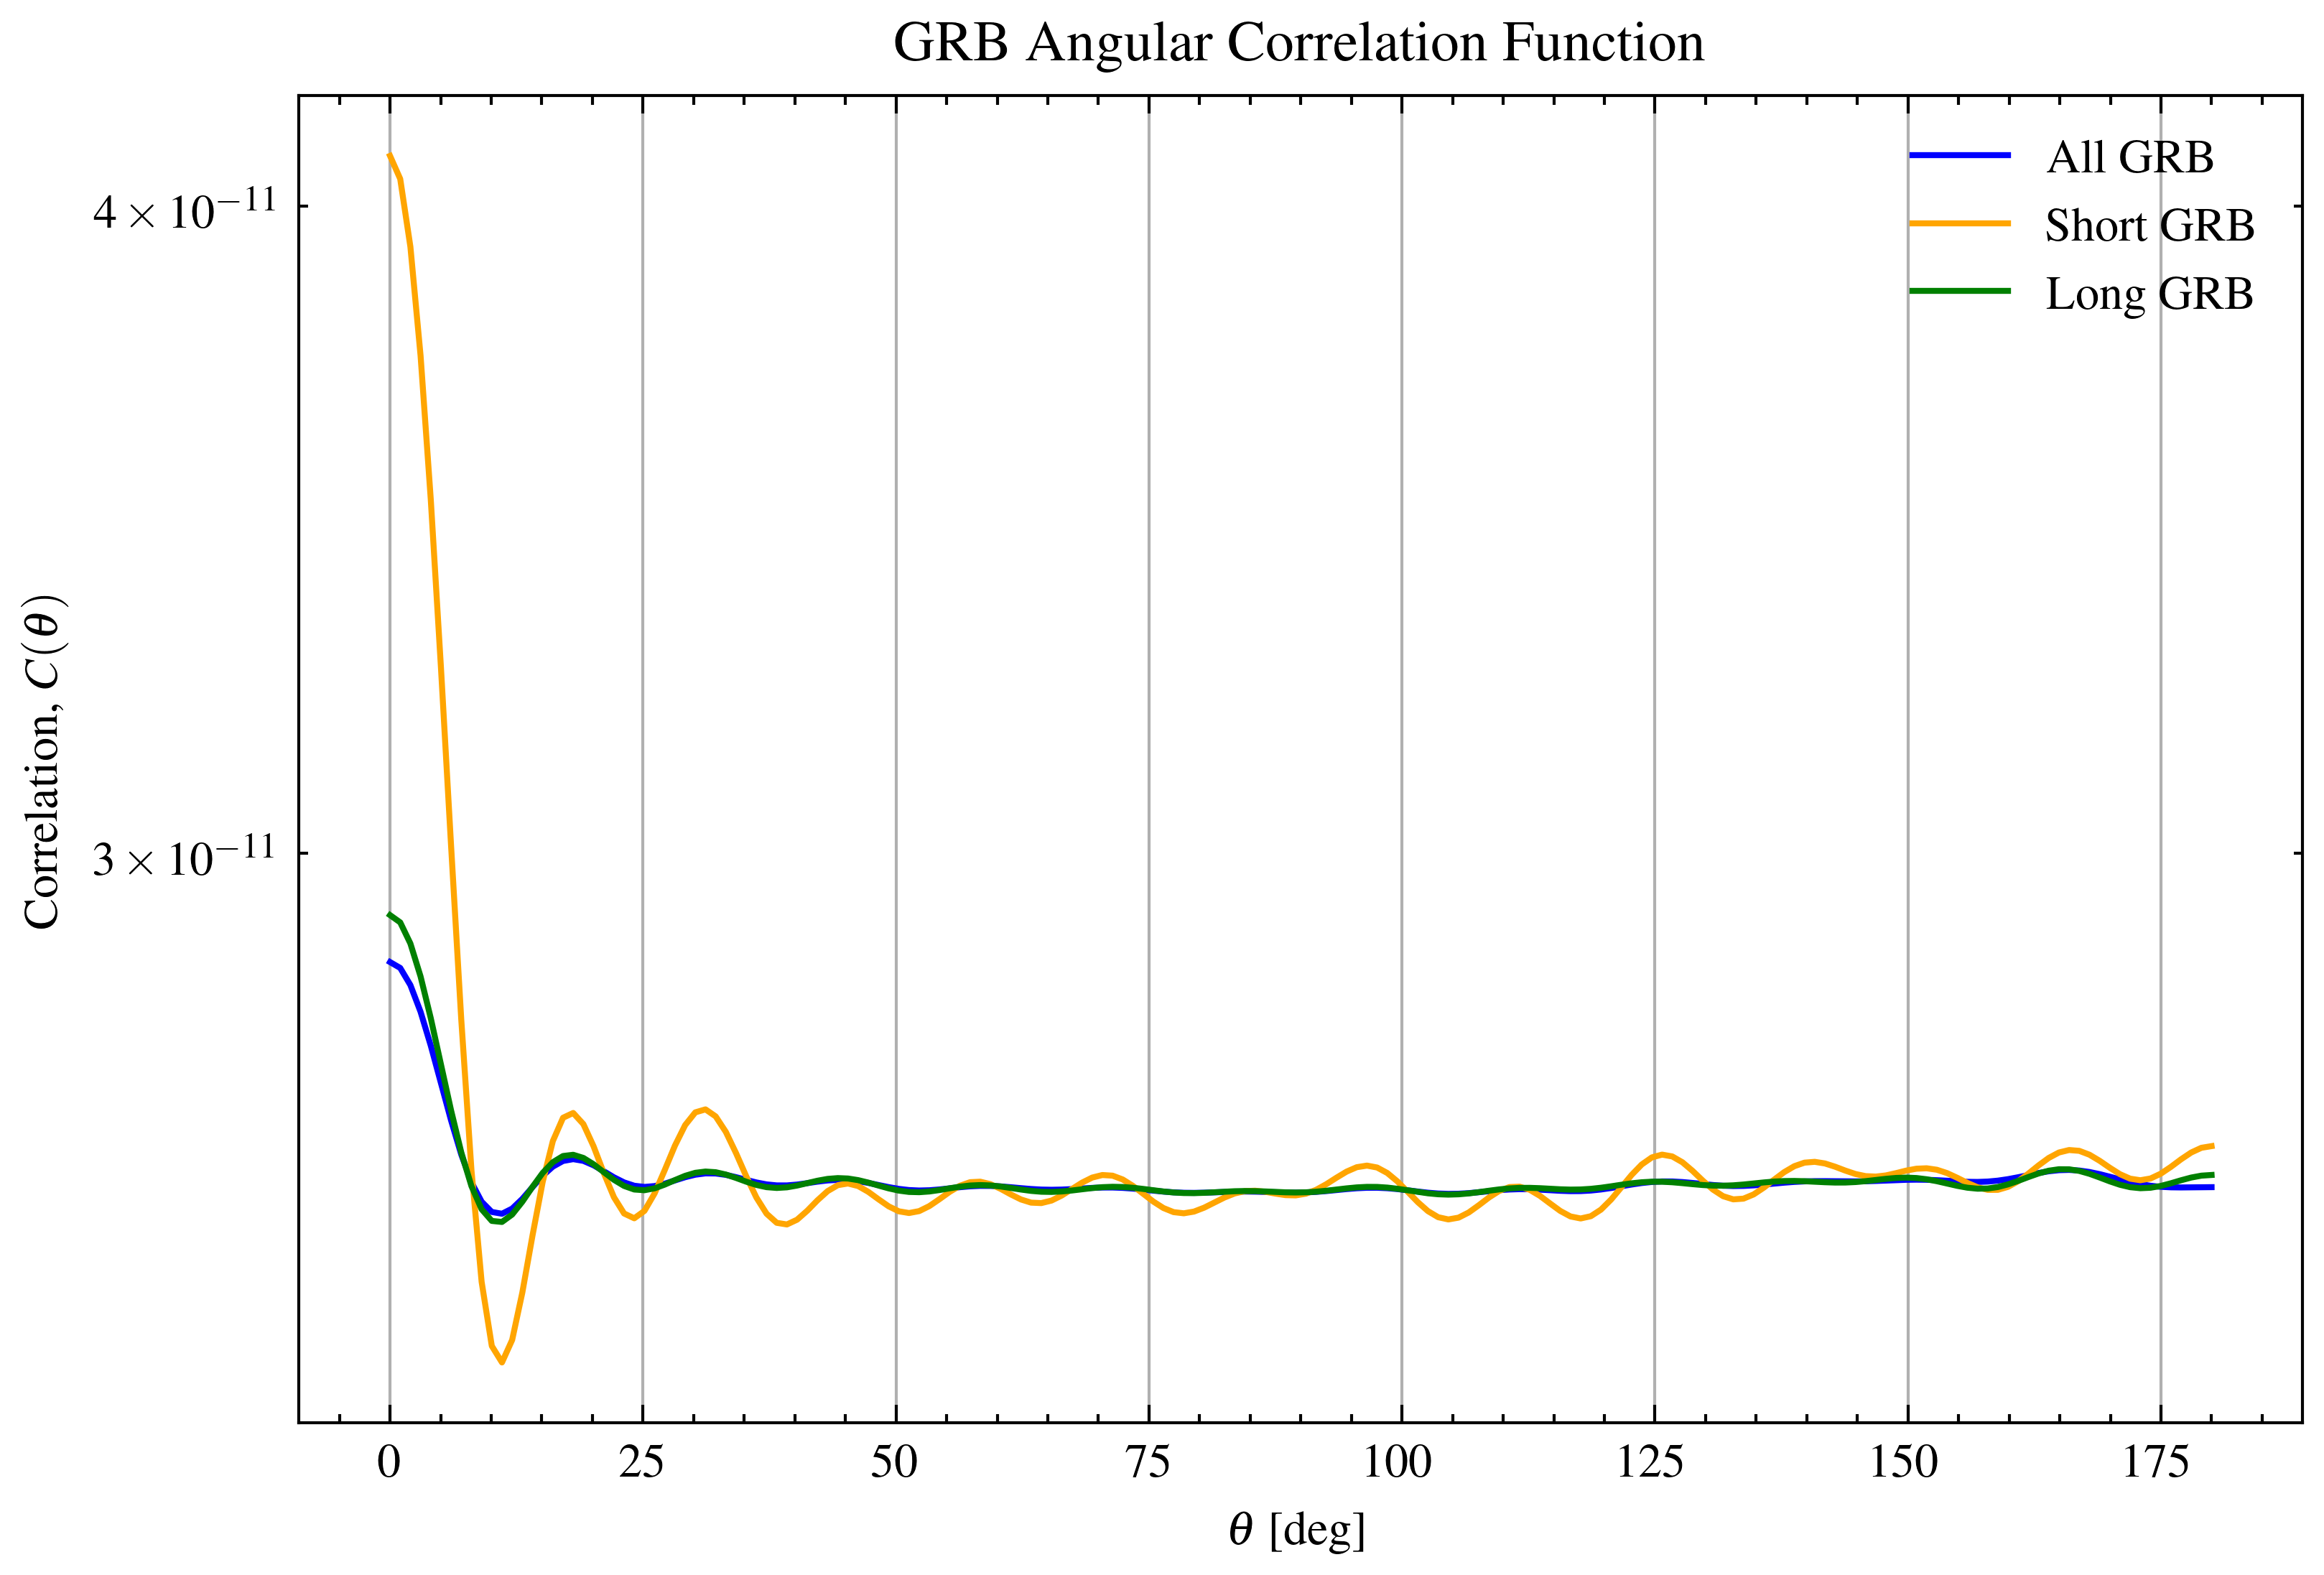

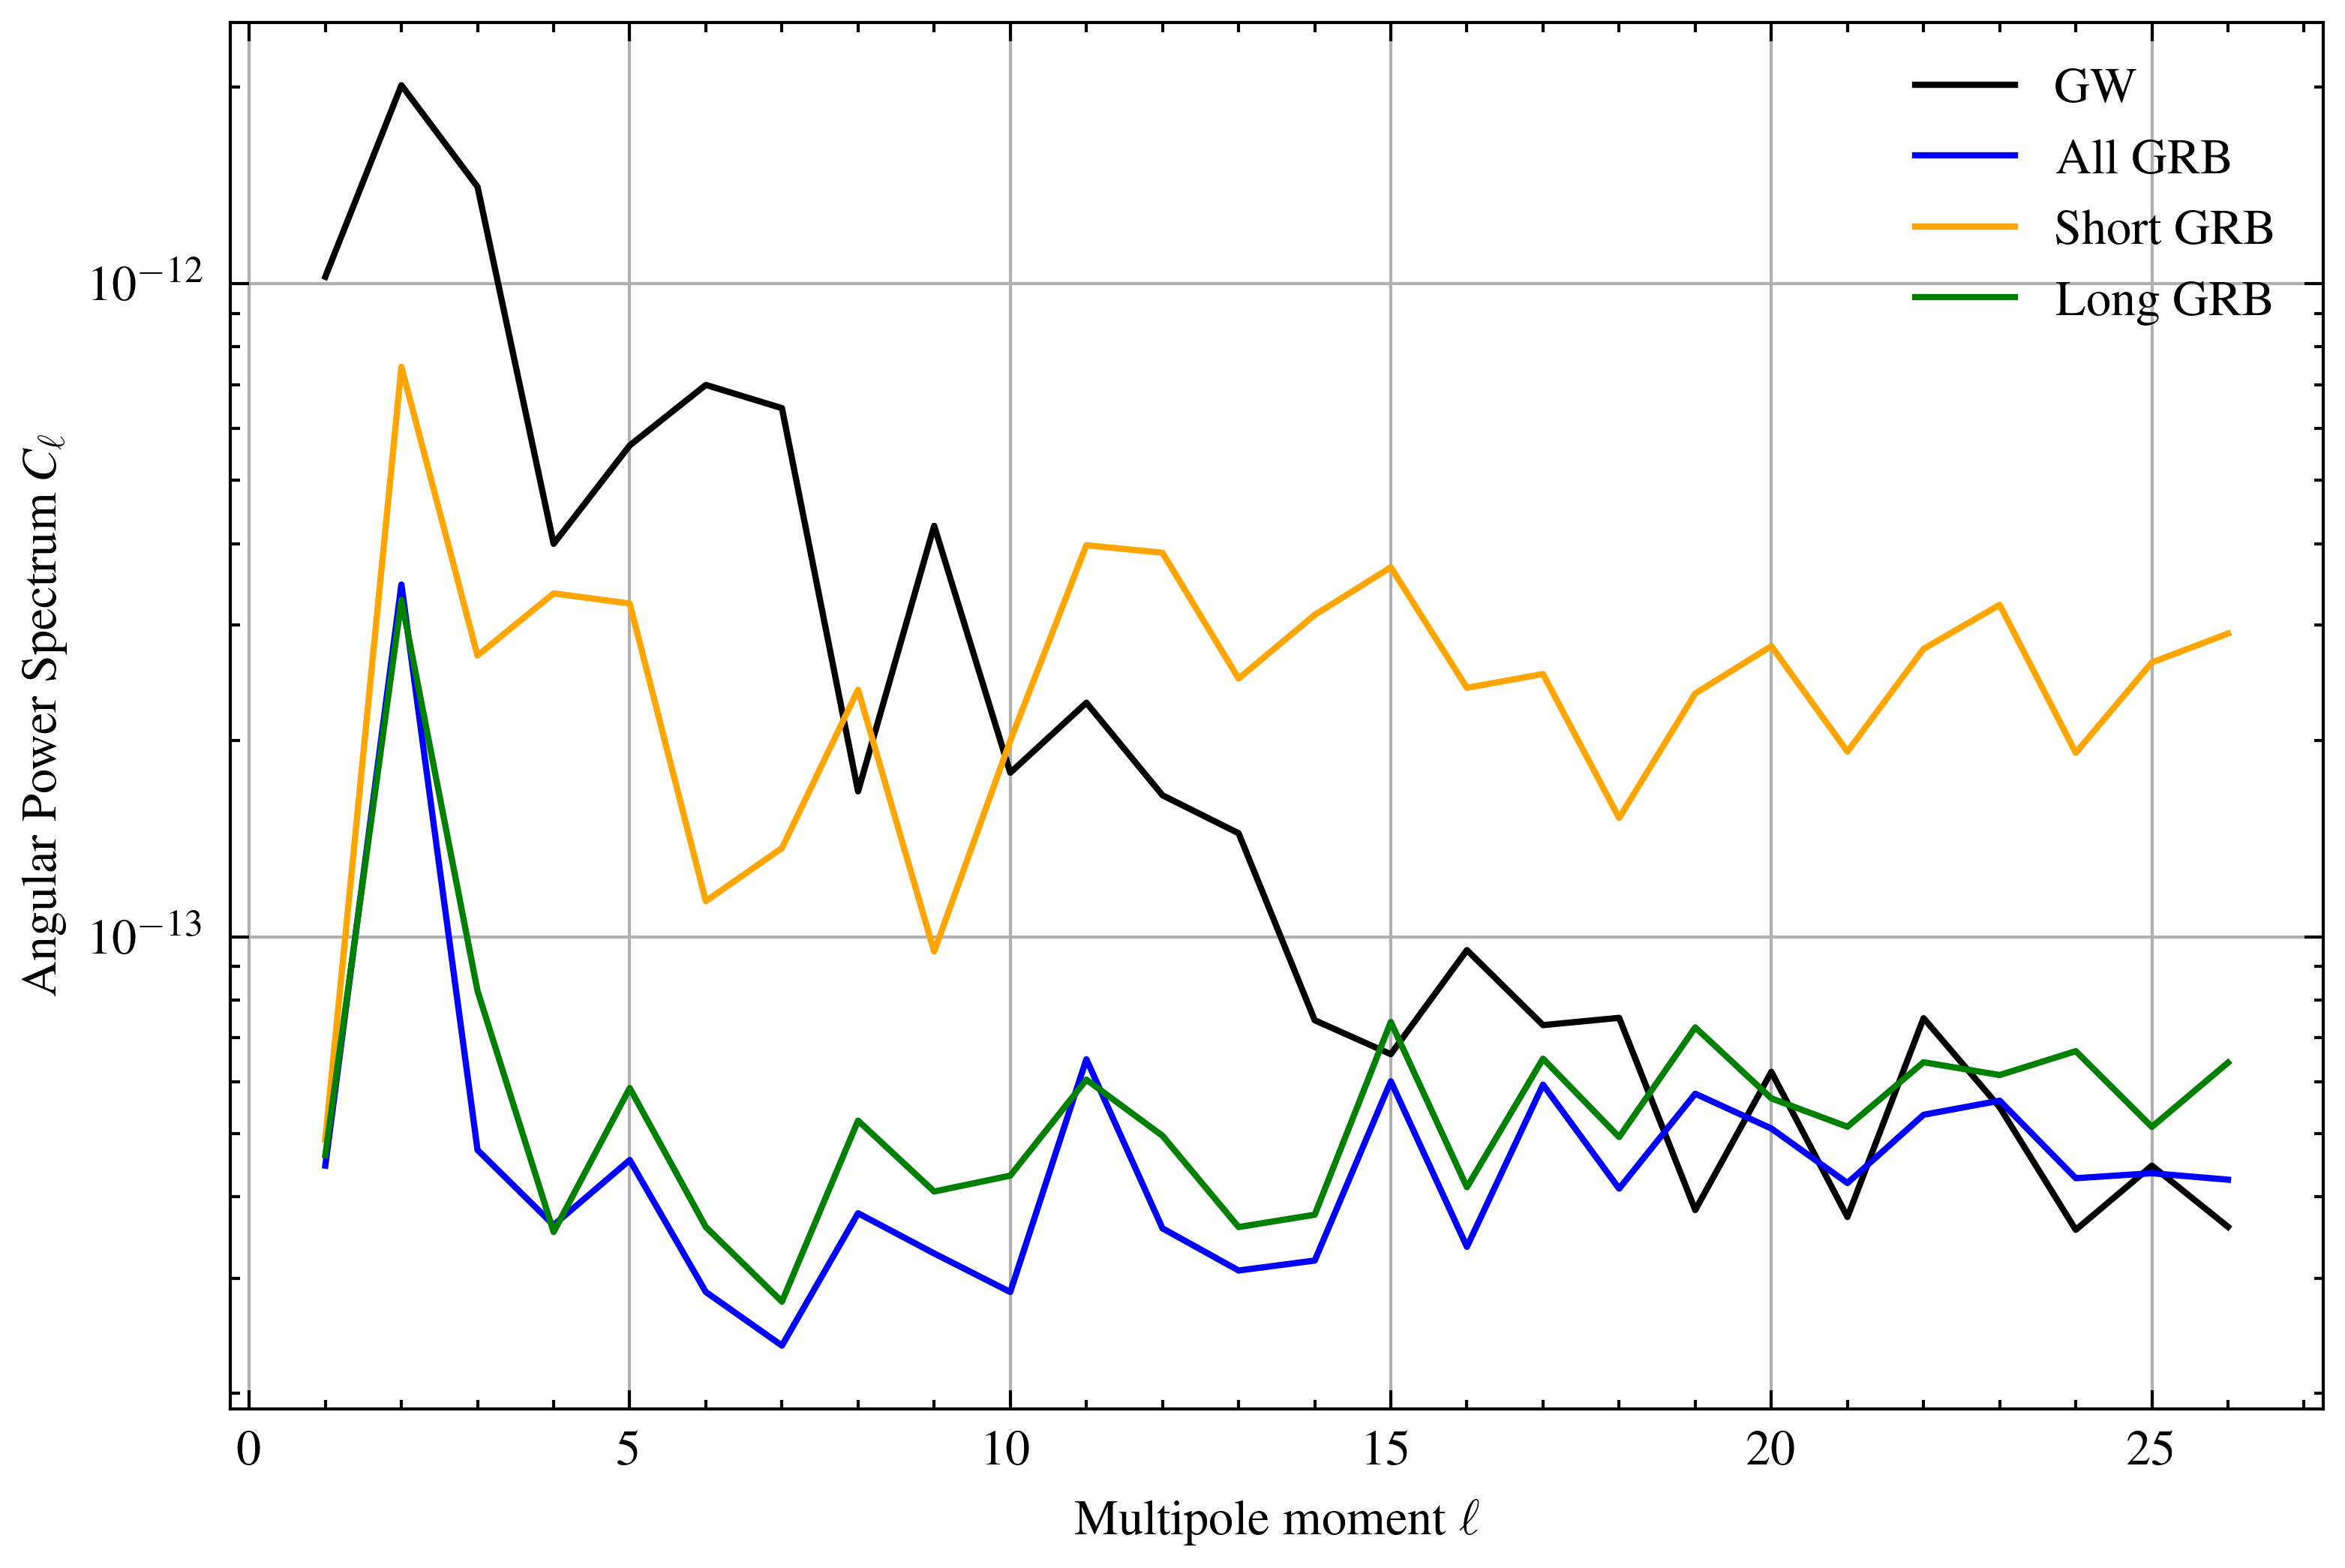

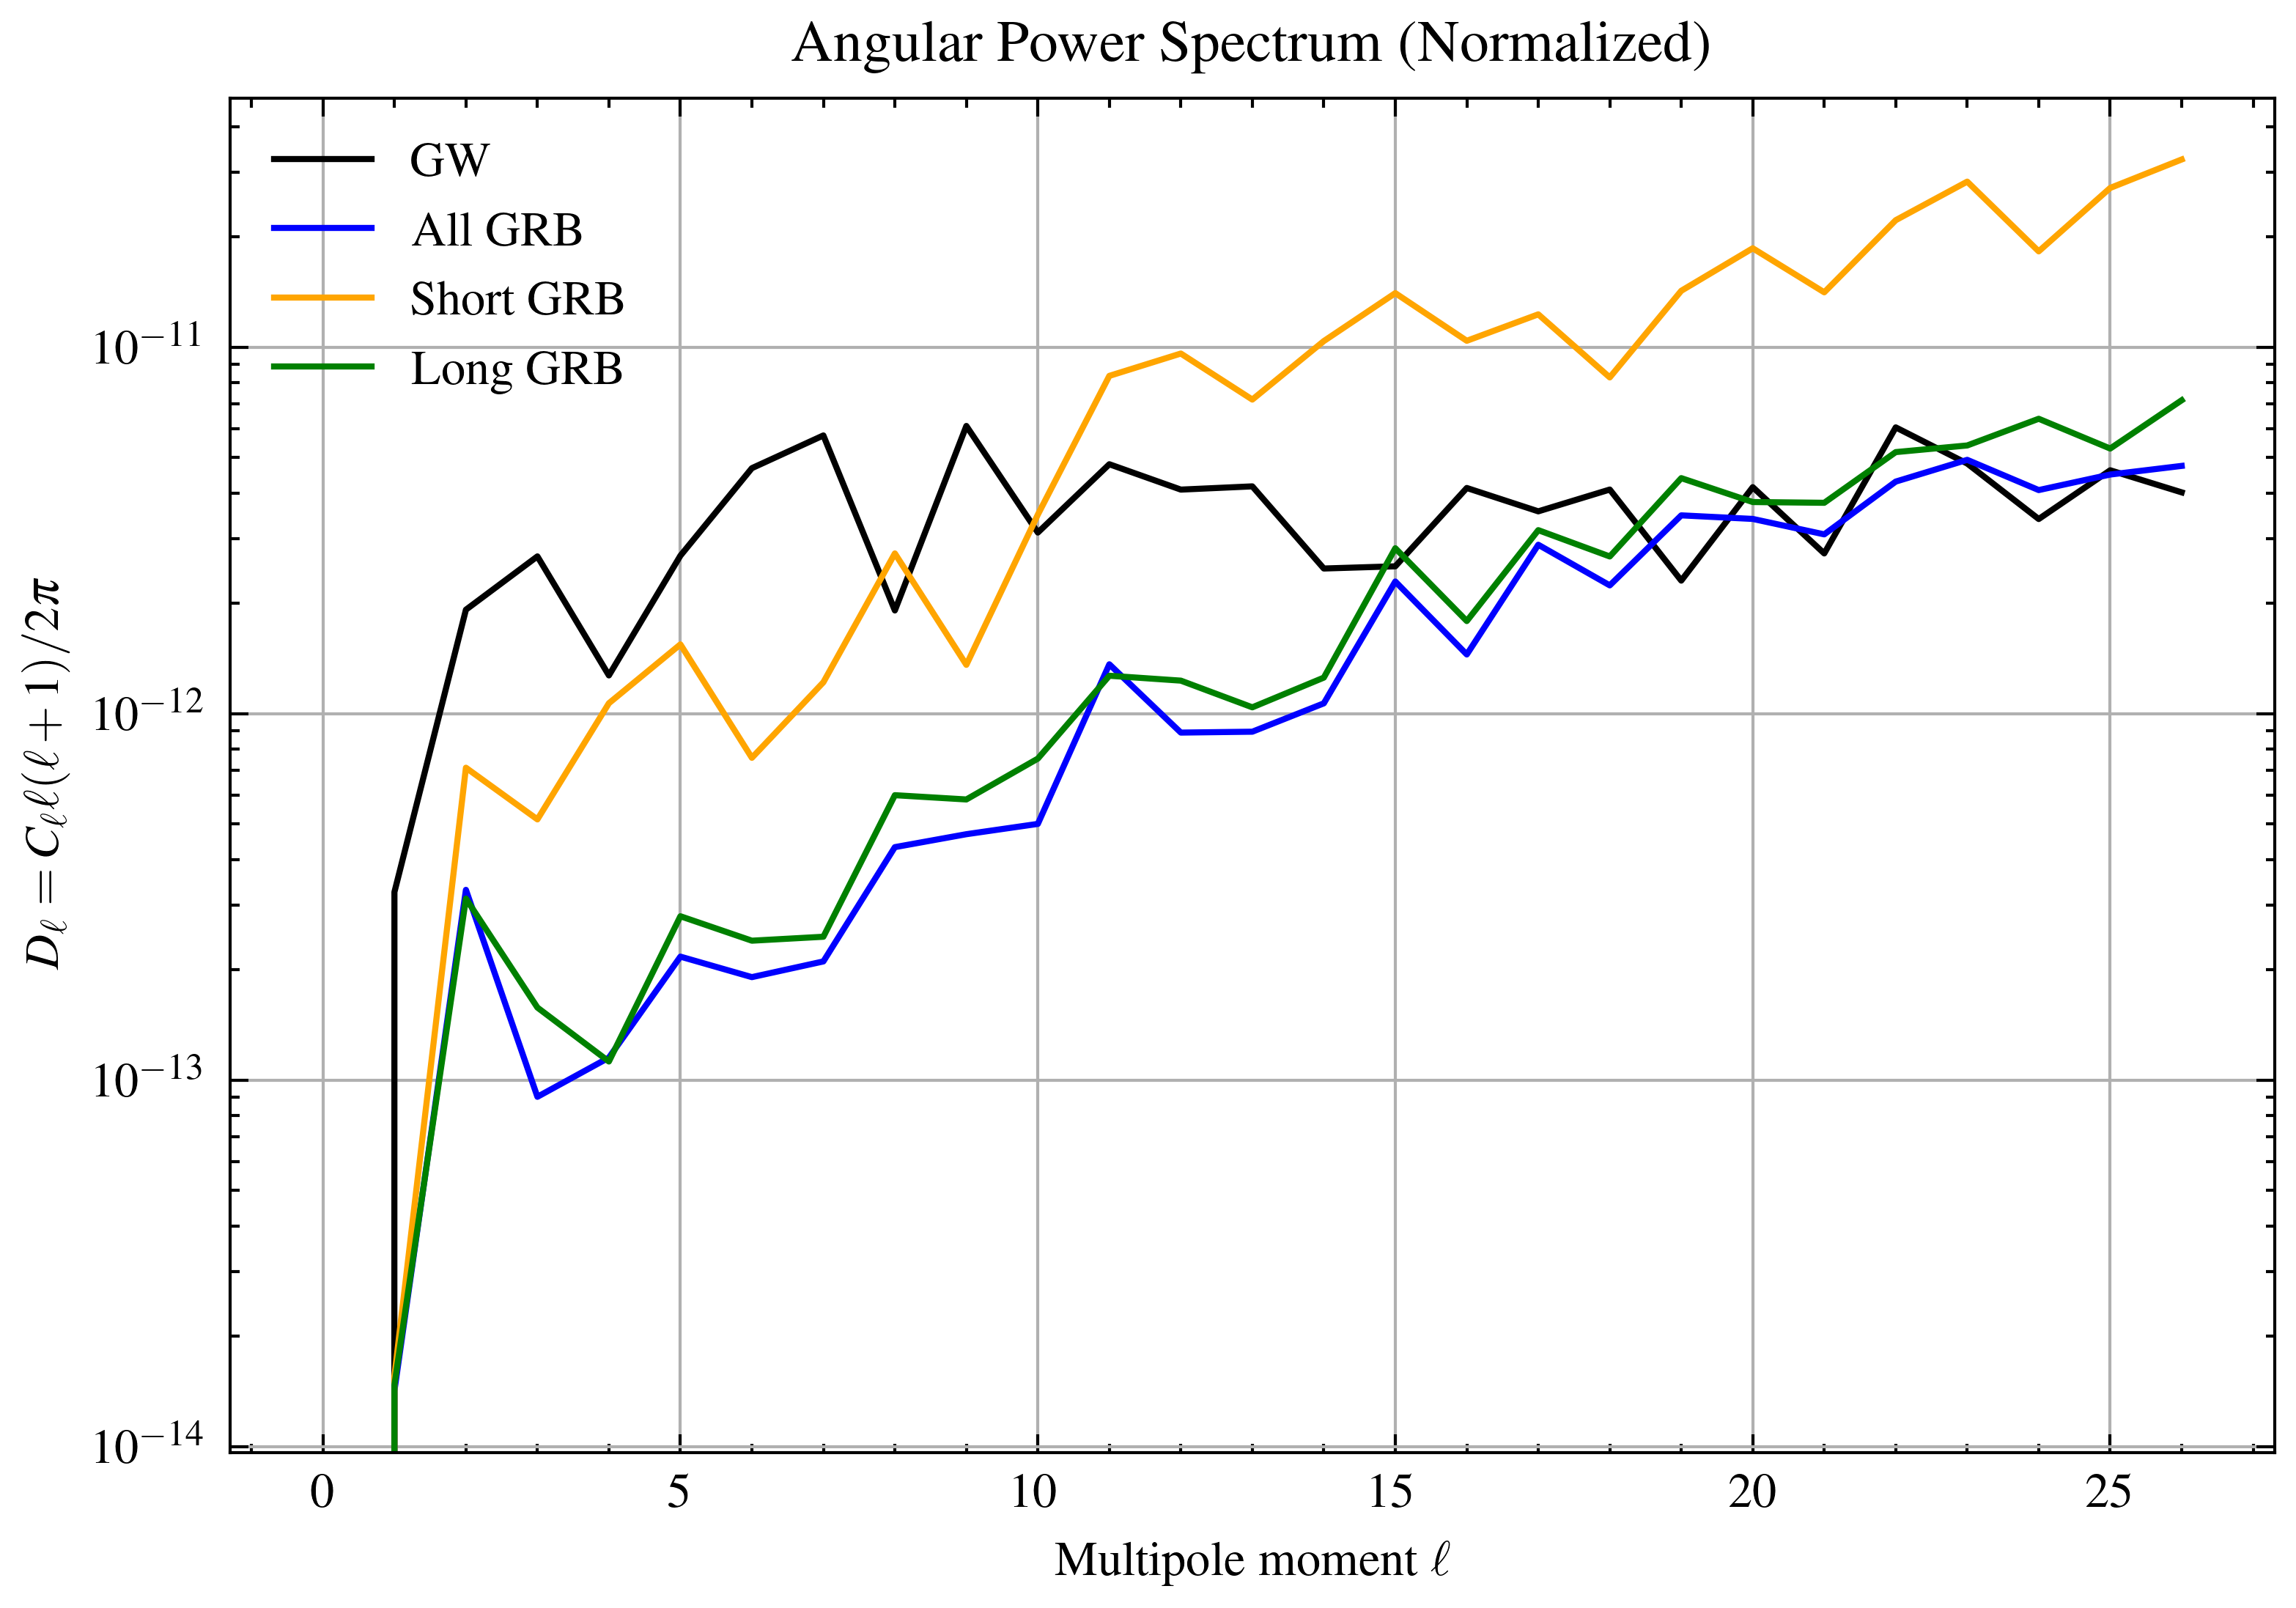

In [5]:
# set maximum l for cut-off in power spectrum, auto-correlations, etc.
lmax = 26

### correlation funcdtion and power spectrum of GW, GRB, sGRB, and lGRB

cl_GW = alm2cl(map2alm(GW_skymap, lmax=lmax), lmax=lmax)
cl_GRB = alm2cl(map2alm(GRB_full_sm, lmax=lmax), lmax=lmax)
cl_sGRB = alm2cl(map2alm(sGRB_skymap, lmax=lmax), lmax=lmax)
cl_lGRB = alm2cl(map2alm(lGRB_skymap, lmax=lmax), lmax=lmax)

# plot angular correlation function
plot_corr_func([cl_GW, cl_GRB, cl_sGRB, cl_lGRB],
               Cl_labels=['GW', 'All GRB', 'Short GRB', 'Long GRB'],
               colors=['black', 'blue', 'orange', 'green'], figsize=(6,4),
               linestyles=['--', None, None, None], title='Angular Correlation Function', ylog=True)

plot_corr_func(cl_GW, Cl_labels='GW', colors='black', title='GW Angular Correlation Function', ylog=True, figsize=(6,4),)

plot_corr_func([cl_GRB, cl_sGRB, cl_lGRB], figsize=(6,4),
               Cl_labels=['All GRB', 'Short GRB', 'Long GRB'],
               colors=['blue', 'orange', 'green'], title='GRB Angular Correlation Function', ylog=True)

# plot power spectrum
plot_Cls([cl_GW, cl_GRB, cl_sGRB, cl_lGRB],
         Cl_labels=['GW', 'All GRB', 'Short GRB', 'Long GRB'],
         colors=['black', 'blue', 'orange', 'green'], figsize=(6,4),
         linestyles=['-', None, None, None], monopole_term=False, ylabel=r'Angular Power Spectrum $C_\ell$',
         title='', ylog=True)

plot_Dls([cl_GW, cl_GRB, cl_sGRB, cl_lGRB],
         Cl_labels=['GW', 'All GRB', 'Short GRB', 'Long GRB'],
         colors=['black', 'blue', 'orange', 'green'],
         linestyles=['-', None, None, None], figsize=(6,4),
         title='Angular Power Spectrum (Normalized)', ylog=True)

# === end of notebook ===